In [1]:
# ultimate goal: 
# get the trial solution psi_t(x) = A_D(x) + L_D(x)L_M(x)g_M(x) + L_D(x)N(x)

In [2]:
# class ControlPoint:
    
#     def __init__(self, x, psi=None, nx=None, dpsi=None, dim=2):
#         """
#         psi(x) is the function we are solving for
        
#         :param x: coordinate of this control point
#         :param psi: (only for Dirichlet B.C.) psi(x)
#         :param nx: (only for Neumann B.C.) normal vector of this control point
#         :param dpsi: (only for Neumann B.C.) nx dot grad(psi(x)) = dpsi
#         :param dim: dimension of this control point
#         """

In [3]:
# class Interpolator:
    
#     """Methods here can be write on top of some general thin plate spline implementation?"""
    
#     def fit_length_factor(control_points):
#         """
#         list of ControlPoints -> length factor function:
#         if control points are for Dirichlet B.C. then L_D(x)
#         if control points are for Neumann B.C. then L_M(x)
#         """
#         # for 2D boundaries:
#         # sort the control_points by their theta (in polar cordinate)
#         # assign each point the mapped point (equally spaced on a circle)
#         # solve the coefficients F for thin plate spline
#         # return L_D(x)/L_M(x) parameterized by F
        
#         # for 3D boundaries:
#         # how to sort the control_points?
#         # how to assign mapped point? (what does equally spaced mean on a sphere?)
    
#     def fit_dirichlet_bondary(control_points):
#         """
#         the A_D(x) in psi_t(x) = A_D(x) + L_D(x)L_M(x)g_M(x) + L_D(x)N(x)
#         """
#         # again a thin plate spline of the Dirichlet coundary control points? (re-check the paper)
        
#     def fit_normal_vector(control_points):
#         """
#         the g_M(x) in psi_t(x) = A_D(x) + L_D(x)L_M(x)g_M(x) + L_D(x)N(x)
#         involves the function n(x) that map x to the normal vector at that point,
#         this method fit that n(x)
#         """
#         # again a thin plate spline of the Neumann coundary control points? (re-check the paper)

In [4]:
# class GeneralBoundaryCondition:
    
#     def __init__(self, control_points, ith):
#         """
#         control_points should include both Neumann B.C. and Dirichlet B.C.
#         maybe should create different class for them?
#         """
#         # fit L_D(x), L_M(x), A_D(x), n(x)
#         # use the above functions to construct g_M(x)
#         # construct the final trial solution
    
#     def _fit_g_M(L_D, L_M, A_D, nx):
#         """
#         fit g_M(x), called in the initializer
#         maybe this method should be in interpolator?
#         """
    
#     def enforce(self, net, xyz_etc):
    
#     def set_impose_on(self, ith):
#         """
#         conform to the new interface of condition class
#         maybe I should have a base class so that we are not writing this method over and over again...
#         """

Poisson in circular domain where

$$
\partial_x^2 u + \partial_y^2 u = x^2 + y^2.
$$

$$
x^2 + y^2 \leq 1
$$

In [5]:
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, ExampleGenerator2D, Monitor2D
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib notebook

# Simplest Case: Dirichlet B.C on a Circular Boundary

In [6]:
r = 1
def L_D(dimensions):
    dimensions = [d.reshape(-1, 1) for d in dimensions]
    return r**2 - sum(d**2 for d in dimensions)

In [7]:
xs = torch.linspace(-1, 1, 101)
ys = torch.linspace(-1, 1, 101)
xx, yy = torch.meshgrid(xs, ys)
ld = L_D((xx, yy))

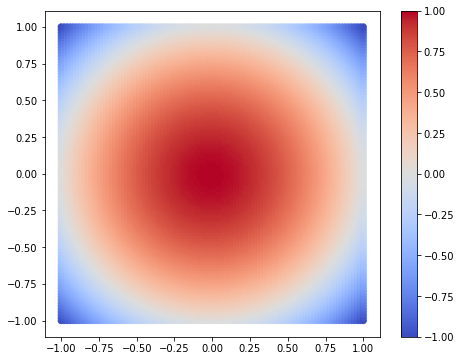

In [8]:
fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.scatter(xx.flatten(), yy.flatten(), c=ld.flatten(), cmap='coolwarm')
cbar = fig.colorbar(cs)

In [9]:
def A_D(xyz_etc):
    return 0.0

In [10]:
def _nn_output(net, xyz_etc, ith):
    original_shape  = xyz_etc[0].shape
    xyz_etc = torch.cat(xyz_etc, 1)
    output = net(xyz_etc)
    return output[:, ith].reshape(original_shape)

class CircularDirichlet:
    
    def __init__(self, r, ith=0):
        def L_D(dimensions):
            dimensions = [d.reshape(-1, 1) for d in dimensions]
            return r**2 - sum(d**2 for d in dimensions)
        def A_D(dimensions):
            return 0.0
        self.L_D = L_D
        self.A_D = A_D
        self.ith = ith
        
    def enforce(self, net, *dimensions):
        return A_D(dimensions) + L_D(dimensions)*_nn_output(net, dimensions, self.ith)
    
    def set_impose_on(self, ith):
        self.ith = ith

<IPython.core.display.Javascript object>


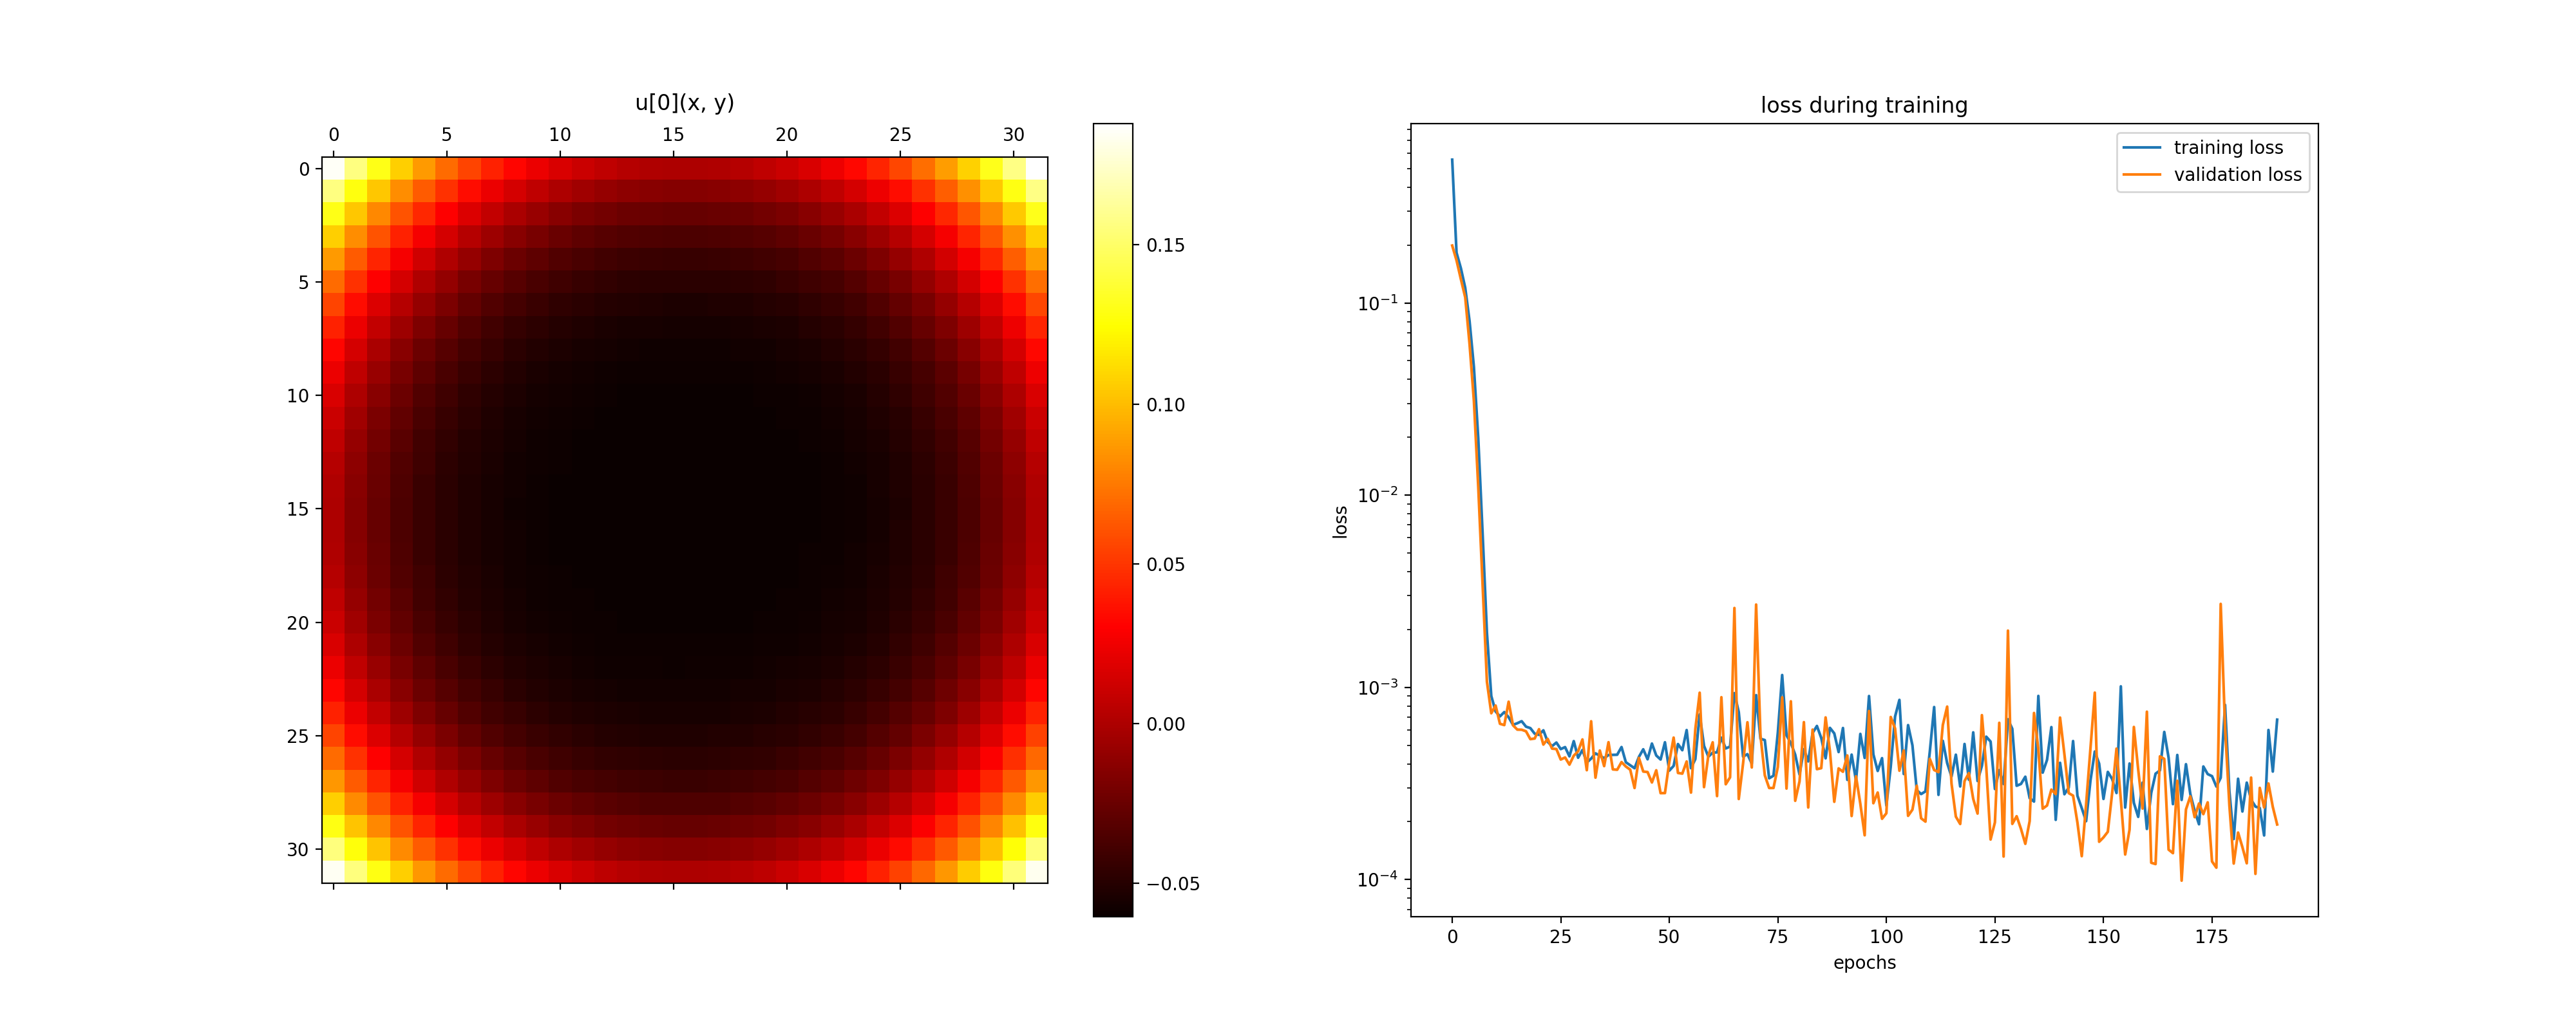

In [11]:
%matplotlib notebook
poisson = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2) - x**2 - y**2
bc  = CircularDirichlet(r=1)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1, actv=nn.Softplus)

solution_neural_net_poisson, _ = solve2D(
    pde=poisson, condition=bc, xy_min=(-1, -1), xy_max=(1, 1),
    net=net, max_epochs=200, train_generator=ExampleGenerator2D(
        (32, 32), (-1, -1), (1, 1), method='equally-spaced-noisy'
    ),
    monitor=Monitor2D(check_every=10, xy_min=(-1, -1), xy_max=(1, 1))
)

In [ ]:
# evaluation